<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/DeteksiSarkasme_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import requests
import json
import gc
import time
from tqdm.notebook import tqdm  # For progress bars in Colab

In [4]:
# Check device and set seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
print(f"Using device: {device}")

def load_data_from_github():
    url = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
    response = requests.get(url)

    if response.status_code == 200:
        data = [json.loads(line) for line in response.text.splitlines()]
        return pd.DataFrame(data)
    else:
        raise Exception(f"Failed to load data: {response.status_code}")


Using device: cpu


In [5]:
# Download data and preprocess
print("Loading dataset from GitHub...")
df = load_data_from_github()
df = df[['headline', 'is_sarcastic']].dropna()
print(f"Dataset loaded with {len(df)} entries")
print("Label Distribution:\n", df['is_sarcastic'].value_counts())

# Tokenization and padding
print("Tokenizing and padding sequences...")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set up tokenizer with limited vocabulary for efficiency
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 30

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = df['is_sarcastic'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders with appropriate batch sizes
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Use larger batch size if on GPU, smaller if on CPU
BATCH_SIZE = 128 if torch.cuda.is_available() else 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2)

# Calculate class weights for imbalanced data
pos_weight_val = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight = torch.tensor([pos_weight_val]).to(device)
print(f"Positive class weight: {pos_weight_val:.4f}")

Loading dataset from GitHub...
Dataset loaded with 28619 entries
Label Distribution:
 is_sarcastic
0    14985
1    13634
Name: count, dtype: int64
Tokenizing and padding sequences...
Positive class weight: 1.0991


In [6]:
# Base model class for all RNN variants
class SarcasmRNNBase(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, rnn_type='rnn'):
        super(SarcasmRNNBase, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Set up RNN layer based on type
        if rnn_type.lower() == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        elif rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        else:
            raise ValueError("rnn_type must be one of: 'rnn', 'lstm', 'gru'")

        self.rnn_type = rnn_type.lower()
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)

        # Process through RNN layer
        if self.rnn_type == 'lstm':
            _, (hidden, _) = self.rnn(embedded)
        else:
            _, hidden = self.rnn(embedded)

        # Concatenate bidirectional outputs
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # Fully connected layers
        out = torch.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.fc2(out)

        return out.squeeze(1)

In [7]:
# Training function
def train_model(model, model_name, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []
    best_val_acc = 0
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct = 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for x_batch, y_batch in train_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            # Statistics
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds == y_batch).sum().item()

            # Update progress bar
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / len(train_loader.dataset)
        train_loss = total_loss / len(train_loader)
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        y_probs, y_true = [], []

        with torch.no_grad():
            val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")
            for x_batch, y_batch in val_bar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                # Store probabilities and true labels
                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                val_correct += (preds == y_batch).sum().item()

                y_probs.extend(probs.cpu().numpy())
                y_true.extend(y_batch.cpu().numpy())

                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = val_correct / len(test_loader.dataset)
        val_loss = val_loss / len(test_loader)
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pt")

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Load best model for evaluation
    model.load_state_dict(torch.load(f"{model_name}_best.pt"))
    return model, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

In [8]:
# Evaluation function
def evaluate_model(model, test_loader, model_name):
    model.eval()
    y_probs, y_true = [], []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            probs = torch.sigmoid(outputs)

            y_probs.extend(probs.cpu().numpy())
            y_true.extend(y_batch.numpy())

    y_probs = np.array(y_probs)
    y_true = np.array(y_true)
    y_preds = (y_probs >= 0.5).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    f1_sq = f1 ** 2
    auc = roc_auc_score(y_true, y_probs)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC: {auc:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f"{model_name}_roc.png")
    plt.show()

    return acc, precision, recall, f1_sq, auc

In [9]:
# Plot training history
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc_hist, label='Train Acc', marker='o')
    plt.plot(val_acc_hist, label='Val Acc', marker='s')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_hist, label='Train Loss', marker='o')
    plt.plot(val_loss_hist, label='Val Loss', marker='s')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{model_name}_history.png")
    plt.show()

In [10]:
# Model hyperparameters
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)
embedding_dim = 128
hidden_dim = 128
output_dim = 1
learning_rate = 0.001
num_epochs = 10

# Dictionary to store model results
results = {}

# Function to run full model training and evaluation
def run_model(rnn_type):
    model_name = rnn_type.upper()
    print(f"\n{'='*50}\nTraining {model_name} Model\n{'='*50}")

    # Initialize model
    model = SarcasmRNNBase(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        rnn_type=rnn_type
    ).to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    model, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(
        model, model_name, train_loader, test_loader, criterion, optimizer, epochs=num_epochs
    )

    # Evaluate model
    metrics = evaluate_model(model, test_loader, model_name)

    # Plot training history
    plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, model_name)

    # Clean memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

    return metrics




Running RNN model...

Training RNN Model


Epoch 1/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.5623, Acc: 0.7124 | Val Loss: 0.4809, Acc: 0.7767


Epoch 2/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.4145, Acc: 0.8190 | Val Loss: 0.4171, Acc: 0.8146


Epoch 3/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.3186, Acc: 0.8687 | Val Loss: 0.4132, Acc: 0.8270


Epoch 4/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2393, Acc: 0.9080 | Val Loss: 0.4084, Acc: 0.8445


Epoch 5/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.1776, Acc: 0.9340 | Val Loss: 0.4524, Acc: 0.8456


Epoch 6/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.1291, Acc: 0.9539 | Val Loss: 0.5368, Acc: 0.8421


Epoch 7/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0884, Acc: 0.9700 | Val Loss: 0.6056, Acc: 0.8436


Epoch 8/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0585, Acc: 0.9807 | Val Loss: 0.7453, Acc: 0.8422


Epoch 9/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0399, Acc: 0.9866 | Val Loss: 0.9135, Acc: 0.8414


Epoch 10/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 1.1036, Acc: 0.8421
Training completed in 234.64 seconds


<ipython-input-7-0e137c00bfb7>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best.pt"))



RNN Results:
Accuracy: 0.8456
Precision: 0.8048
Recall: 0.8922
F1 Score: 0.8463
F1 Squared: 0.7162
AUC: 0.9239


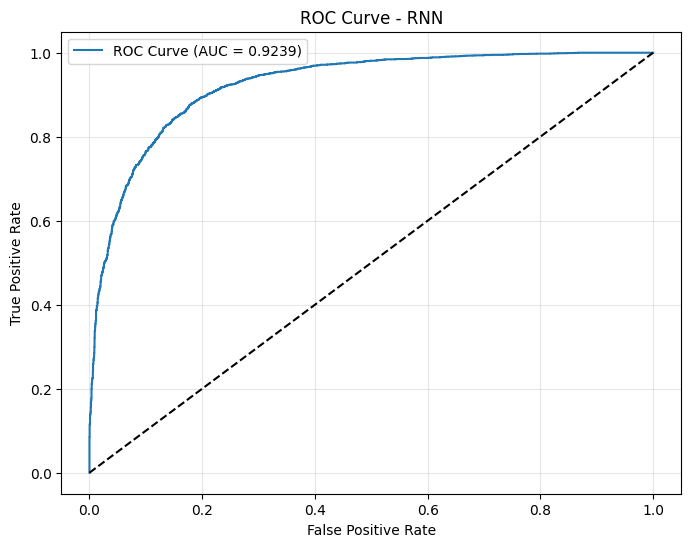

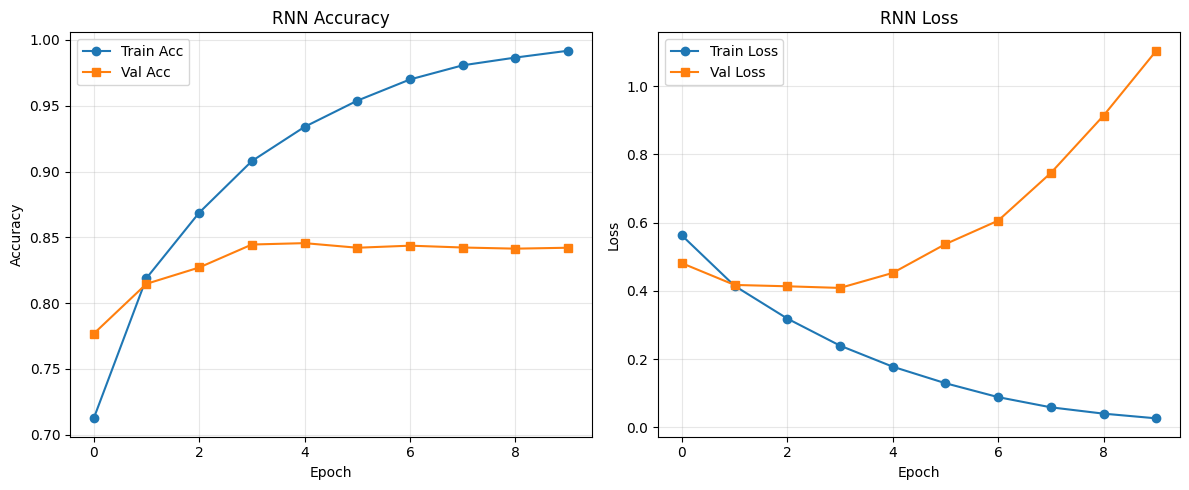

In [12]:
# Dictionary to store results
results = {}

# Run RNN model
print("\nRunning RNN model...")
results['rnn'] = run_model('rnn')


Running LSTM model...

Training LSTM Model


Epoch 1/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.5060, Acc: 0.7543 | Val Loss: 0.4375, Acc: 0.8066


Epoch 2/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.3303, Acc: 0.8633 | Val Loss: 0.3873, Acc: 0.8340


Epoch 3/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2146, Acc: 0.9167 | Val Loss: 0.3738, Acc: 0.8464


Epoch 4/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.1217, Acc: 0.9568 | Val Loss: 0.4767, Acc: 0.8512


Epoch 5/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0615, Acc: 0.9801 | Val Loss: 0.5622, Acc: 0.8461


Epoch 6/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.7330, Acc: 0.8433


Epoch 7/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 1.0021, Acc: 0.8519


Epoch 8/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 1.0932, Acc: 0.8470


Epoch 9/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 1.1249, Acc: 0.8443


Epoch 10/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 1.1324, Acc: 0.8438
Training completed in 530.74 seconds


<ipython-input-7-0e137c00bfb7>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best.pt"))



LSTM Results:
Accuracy: 0.8519
Precision: 0.8413
Recall: 0.8493
F1 Score: 0.8453
F1 Squared: 0.7145
AUC: 0.9275


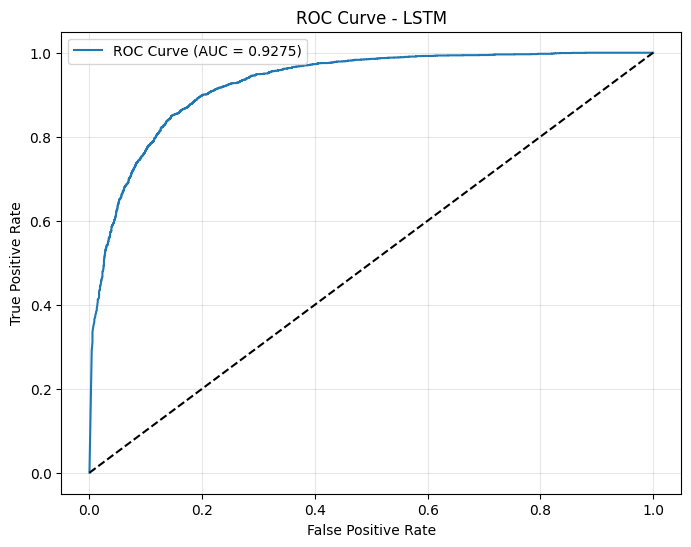

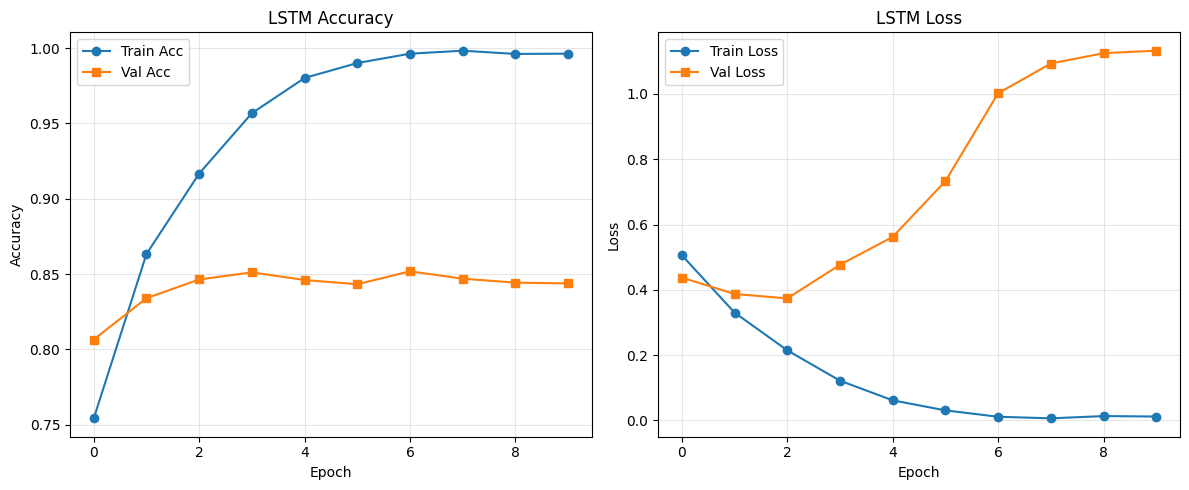

In [13]:
# Run LSTM model
print("\nRunning LSTM model...")
results['lstm'] = run_model('lstm')


Running GRU model...

Training GRU Model


Epoch 1/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.5165, Acc: 0.7484 | Val Loss: 0.4336, Acc: 0.7989


Epoch 2/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.3419, Acc: 0.8570 | Val Loss: 0.3647, Acc: 0.8419


Epoch 3/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2261, Acc: 0.9110 | Val Loss: 0.3906, Acc: 0.8475


Epoch 4/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.1240, Acc: 0.9533 | Val Loss: 0.4661, Acc: 0.8482


Epoch 5/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0552, Acc: 0.9807 | Val Loss: 0.6279, Acc: 0.8408


Epoch 6/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.8801, Acc: 0.8485


Epoch 7/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 1.0112, Acc: 0.8473


Epoch 8/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 1.1143, Acc: 0.8454


Epoch 9/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 1.0711, Acc: 0.8384


Epoch 10/10 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 1.2265, Acc: 0.8447
Training completed in 425.58 seconds


<ipython-input-7-0e137c00bfb7>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best.pt"))



GRU Results:
Accuracy: 0.8485
Precision: 0.8350
Recall: 0.8500
F1 Score: 0.8424
F1 Squared: 0.7097
AUC: 0.9275


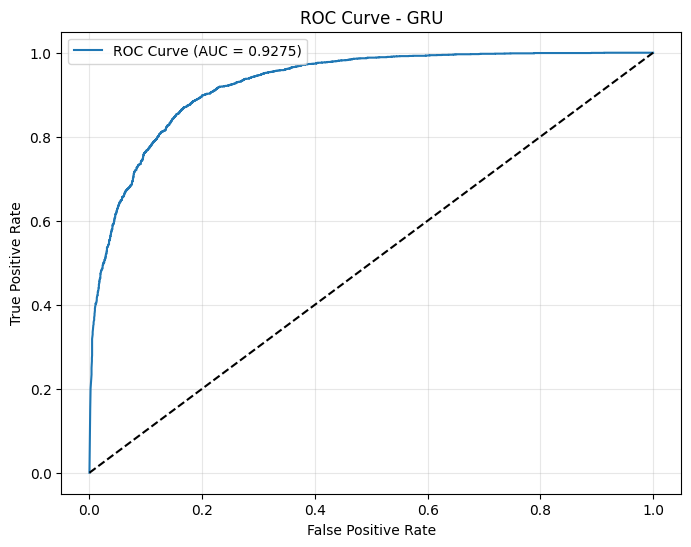

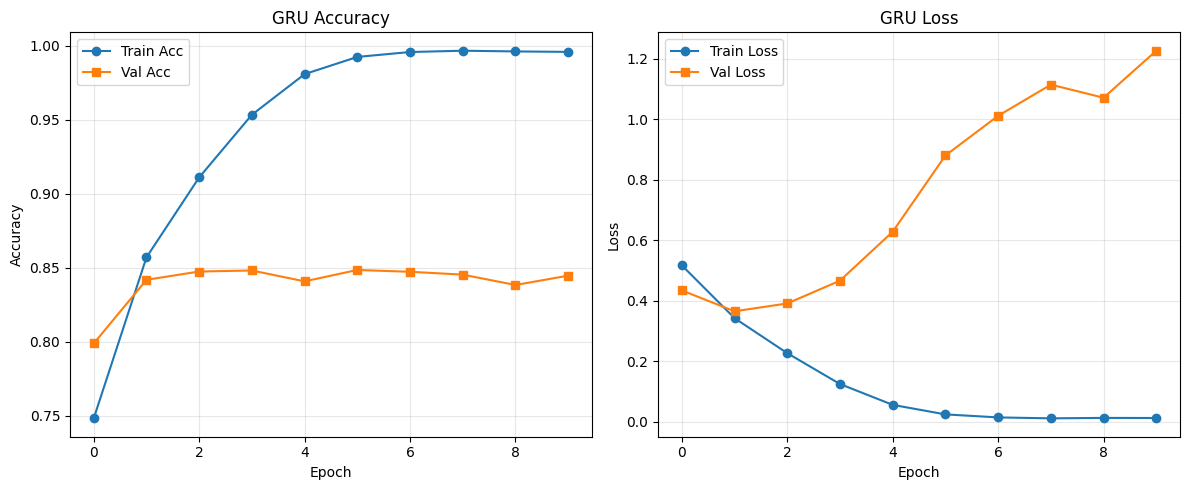

In [14]:
# Run GRU model
print("\nRunning GRU model...")
results['gru'] = run_model('gru')


In [15]:
# Compare model results
print("\n" + "="*50)
print("Model Comparison")
print("="*50)
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Squared", "AUC"]
print(f"{headers[0]:<10} {headers[1]:<10} {headers[2]:<10} {headers[3]:<10} {headers[4]:<10} {headers[5]:<10}")
print("-"*60)

for model_name, metrics in results.items():
    acc, prec, rec, f1_sq, auc = metrics
    print(f"{model_name.upper():<10} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1_sq:<10.4f} {auc:<10.4f}")



Model Comparison
Model      Accuracy   Precision  Recall     F1 Squared AUC       
------------------------------------------------------------
RNN        0.8456     0.8048     0.8922     0.7162     0.9239    
LSTM       0.8519     0.8413     0.8493     0.7145     0.9275    
GRU        0.8485     0.8350     0.8500     0.7097     0.9275    


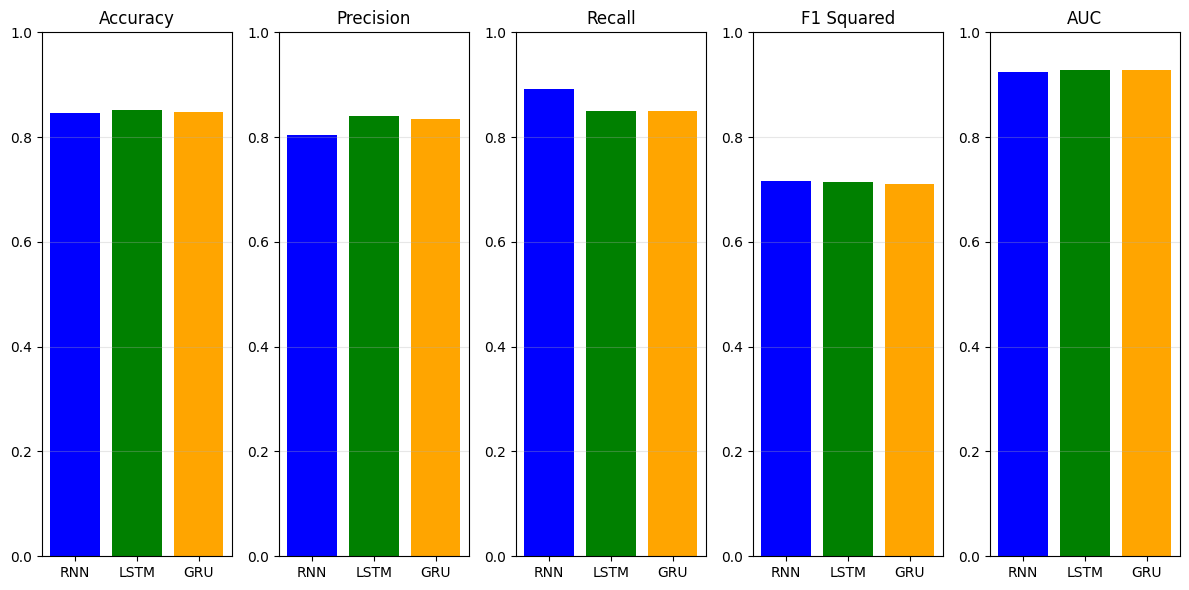

In [16]:
# Plot comparison bar chart
plt.figure(figsize=(12, 6))
models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Squared", "AUC"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)
    values = [results[model][i] for model in models]
    plt.bar([m.upper() for m in models], values, color=['blue', 'green', 'orange'])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()
